# KNN Shapley

This notebook shows how to calculate Shapley values of the KNN algorithm. Compared to the general Shapley implementation, which has an exponential computation complexity, KNN-Shapley can be computed in linear time, as explained in [this paper](http://www.vldb.org/pvldb/vol12/p1610-jia.pdf). Let's start from importing the main libraries.

In [24]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from valuation.utils.plotting import plot_iris

from valuation.shapley.knn import knn_shapley
from valuation.utils import Dataset

Through the Dataset class we can load the iris sklearn dataset. For more info on the data see [the dedicated sklearn page](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

In [25]:
data = Dataset.from_sklearn(datasets.load_iris())

The next cell shows how to calculate the Shapley values using the pyDVL knn_shapley method

In [26]:
knn = KNeighborsClassifier(n_neighbors=5)
shapley_values = knn_shapley(data, knn)
values = np.array([shapley_values[k] for k in shapley_values])

30it [00:00, 4343.28it/s]


Let's now plot the labeles distribution and Shapley distributions as a function of petal and sepal length

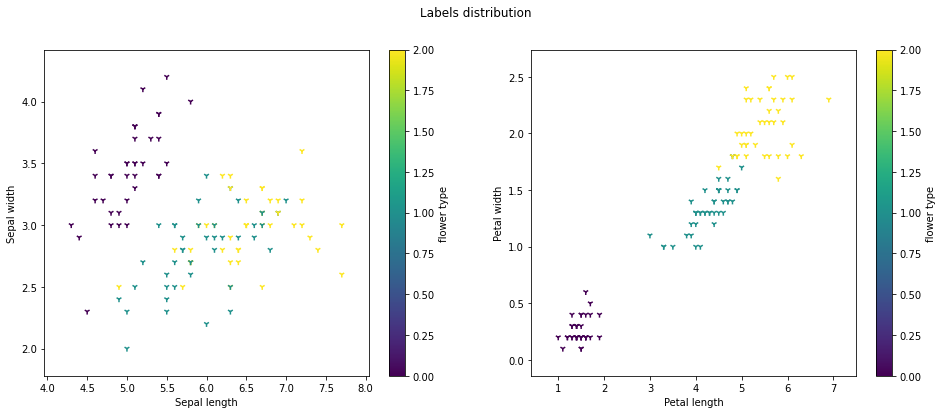

In [27]:
plot_iris(data, colorbal_label='flower type', suptitle='Labels distribution')

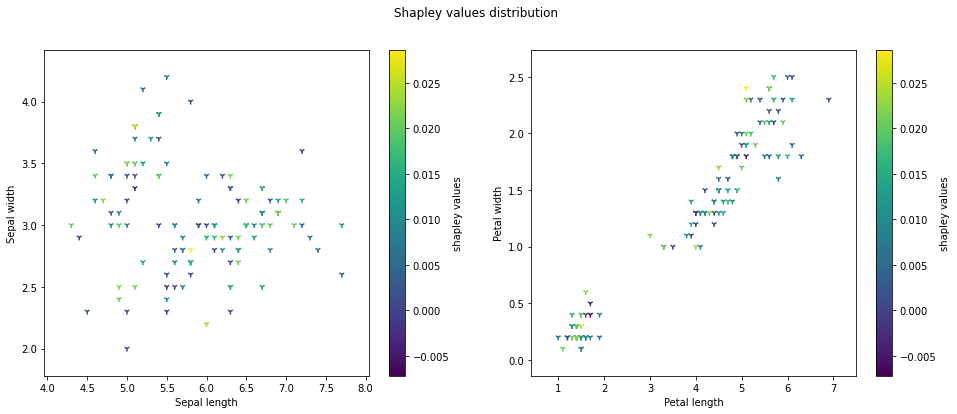

In [28]:
plot_iris(data, colors=values, colorbal_label='shapley values', suptitle='Shapley values distribution')

Shapley values uniformly distributed across the 3 labels, as expected, since to have an accurate model we need information on all of them.

## Corrupting labels

As done in the notebook for general Shapley, we can corrupt some of the train labels and see how their Shapley value changes with respect to the other non-corrupted points. 

In [29]:
from copy import deepcopy
corrupted_dataset = deepcopy(data)
corrupted_dataset.y_train[:10] = [(value + 1)%3 for value in corrupted_dataset.y_train[:10]]
knn = KNeighborsClassifier(n_neighbors=5)
corrupted_shapley = knn_shapley(corrupted_dataset, knn)

30it [00:00, 5075.19it/s]


If we take the average corrupted shapley value and compared it to non-corrupted ones, we notice that on average anomalous points tend to have a much lower score, i.e. tend to be much less valuable to the model, as expected.

In [22]:
corrupted_shapley_values = [corrupted_shapley[idx] for idx in range(10)]
print("Mean shapley value of corrupted points:", np.mean(corrupted_shapley_values))

Mean shapley value of corrupted points: -0.020360592748453733


In [23]:
correct_shapley_values = [corrupted_shapley[idx] for idx in range(10, len(corrupted_shapley))]
print("Mean shapley value of regular points:", np.mean(correct_shapley_values))

Mean shapley value of regular points: 0.008200670473191582
